The downstream study based on sklearn framework.
====================
Study of the T-seed selection using BDT classifier
-----------------------------
This script contains all of my study based on **BDT - GradientBoostedClassifier**.

Study roadmap 
--------------
1. Train  the first version of Gradient Boosted Classifer with default parameters and without any features engeenering. Just to know baseline score. 
2. Add basic features transforamtion eg. pseudorapidity and abs. 
3. Tune hiperparameters at first number of trees and learining rate 
4. Add linear combination and features's ratios
5. ... 


In [1]:
print ("kernel is alive!")

kernel is alive!


In [2]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.externals import joblib


Welcome to ROOTaaS 6.06/02


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [4]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


Print the features
-------------------------

In [5]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2820225.000000,2.820225e+06,2.820225e+06,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000,2820225.000000
mean,2.151541,2.597007e+04,2.154239e+03,17.786964,2.583371,11.168504,2.711442,-6.605598,0.003993,-0.000770
std,1.450411,3.971438e+06,1.839172e+05,4.672981,4.624577,1.080491,695.398805,562.730757,0.319859,0.073198
min,0.000250,1.112569e+03,1.762072e+00,8.000000,0.000000,8.000000,-2491.031005,-2277.240338,-1.284890,-1.225459
25%,1.053873,3.014385e+03,9.318066e+02,13.000000,0.000000,11.000000,-395.587195,-222.158379,-0.179371,-0.031975
50%,1.714204,5.749199e+03,1.123466e+03,19.000000,0.000000,12.000000,-4.058384,-4.284824,0.004472,-0.000420
75%,2.949078,1.318862e+04,1.370916e+03,22.000000,4.000000,12.000000,399.664220,209.894007,0.190217,0.030538
max,8.999829,4.048456e+09,1.676033e+08,32.000000,23.000000,12.000000,2505.840240,2217.239114,1.358254,0.594471


In [20]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

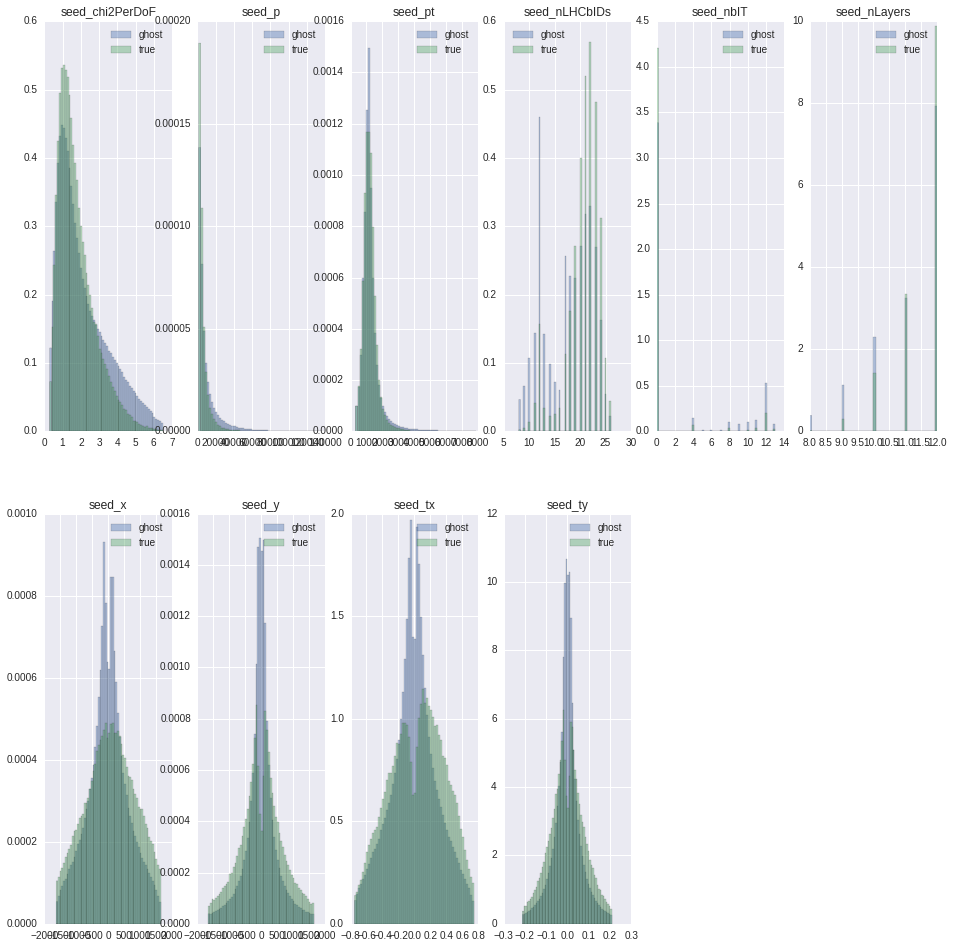

In [6]:
print_features_histograms(features, data.is_true_seed)

In [7]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

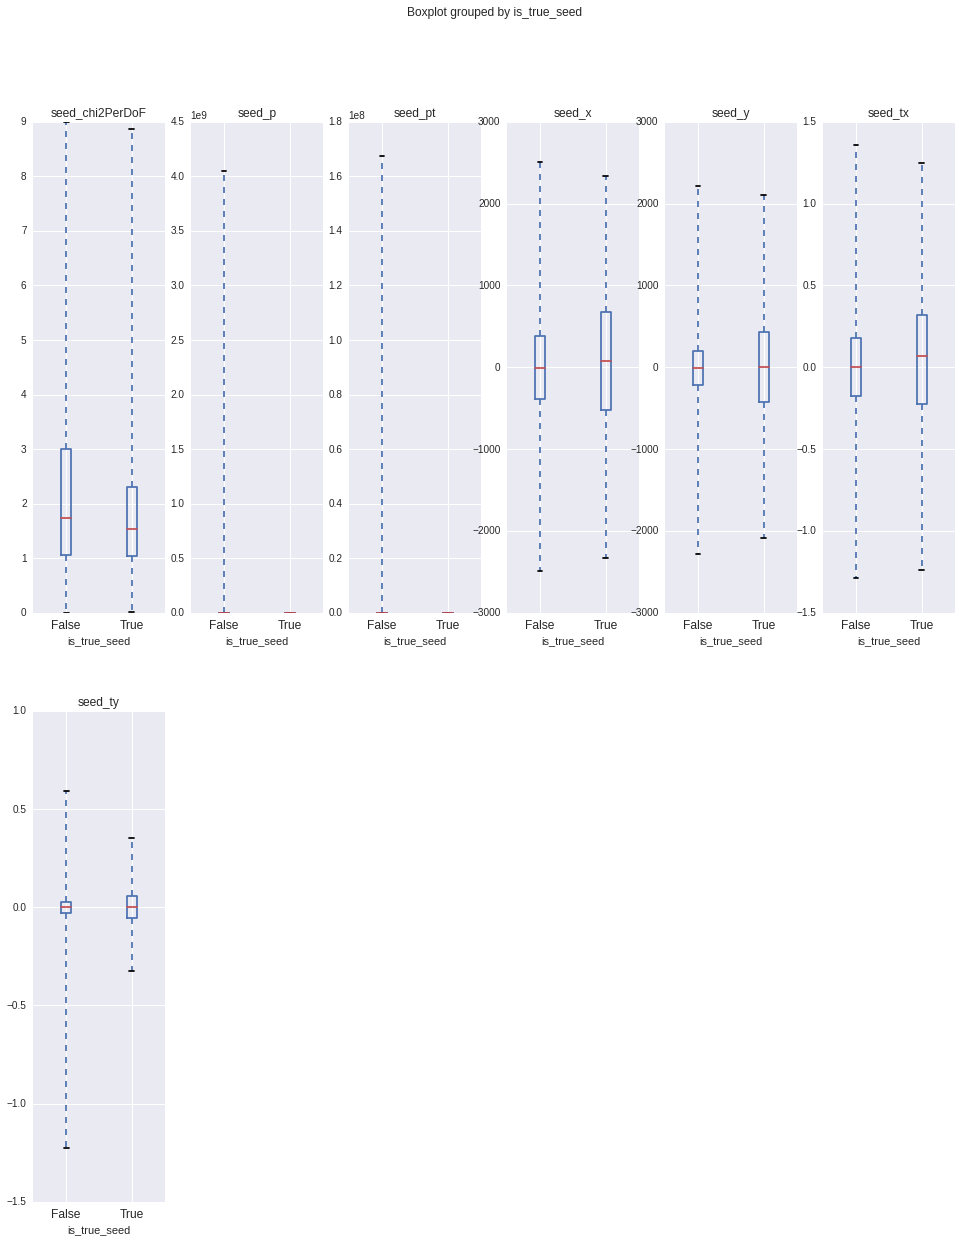

In [8]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

Training of the baselines's clasifiers
=======================

Split data into train and validation sets
----------------------

In [6]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

Boosted Decision Tree clasifier
------------------------------
The above plots present's performance of the BDT. It is one of the best classifier, that can be used as a baseline. 
I just need to tune 3 parameters. 
* Spliting criteria
* tree depth
* number of the trees

In [7]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8)
gb.fit(trainX,trainY)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=13, subsample=0.8, verbose=0, warm_start=False)

In [8]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.79158200838342785

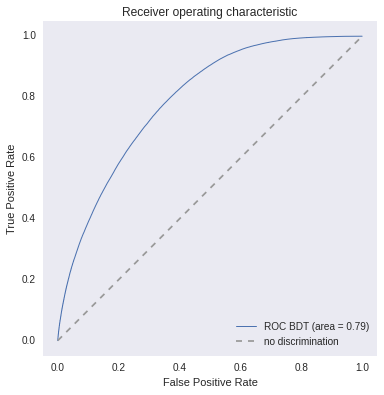

In [12]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Check importance of the features based on the BDT. 

In [10]:
def print_feature_importance(model, features):
    importances = model.feature_importances_
    std = numpy.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = numpy.argsort(importances)[::-1]
    features_names =  list(features.columns.values)

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(features.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, features_names[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(features.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(features.shape[1]), features_names, rotation=70)
    plt.xlim([-1, features.shape[1]])
    plt.show()

Feature ranking:
1. feature seed_chi2PerDoF (0.228547)
2. feature seed_p (0.138747)
3. feature seed_pt (0.132353)
4. feature seed_nLHCbIDs (0.116364)
5. feature seed_nbIT (0.109421)
6. feature seed_nLayers (0.087388)
7. feature seed_x (0.085787)
8. feature seed_y (0.071089)
9. feature seed_tx (0.016196)
10. feature seed_ty (0.014107)


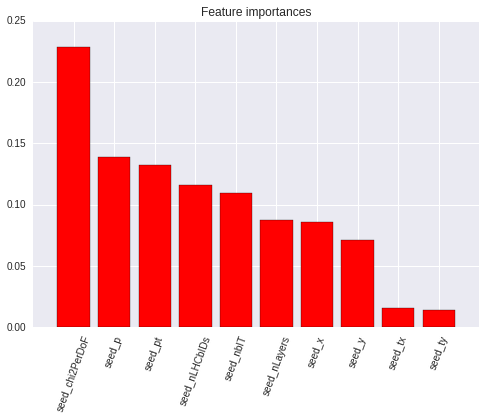

In [13]:
print_feature_importance(gb, features)

Feature Engenering
======================
Add transformated features
-------------------
At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [5]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [6]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


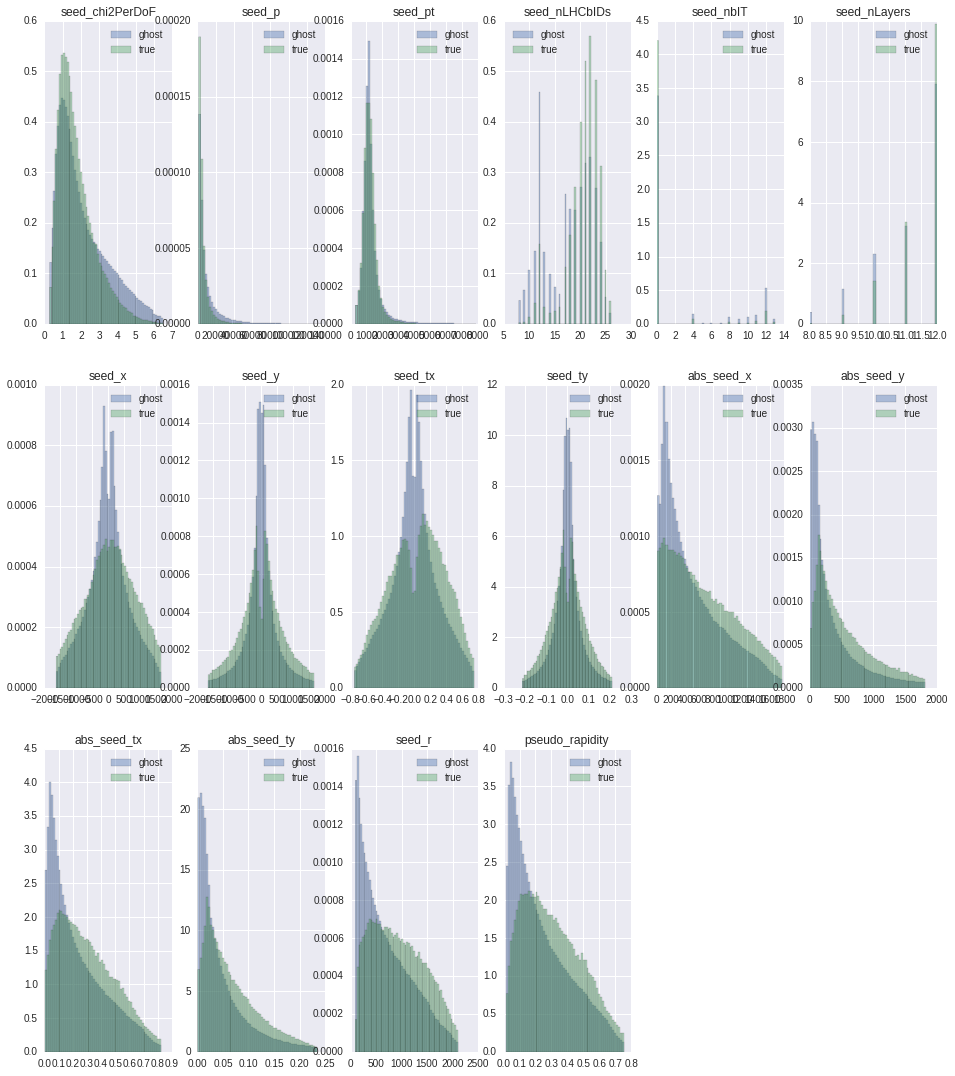

In [11]:
print_features_histograms(new_features, target)

In [7]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )

In [8]:
gb2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8)
gb2.fit(new_trainX,new_trainY)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=13, subsample=0.8, verbose=0, warm_start=False)

In [9]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

0.80031765874788441

In [24]:
print("improved on %f%%")% (80.031765874788441 -79.158200838342785)

improved on 0.873565%


Hyperparameters optimalization
----------------
Let's improve it by serching for the best hyperparameters values. 
In the first iteration I want to find the best values of following hyperparameters 
* The cosidered range of n_estimators is between 50 and 250, step = 50
* learning rate in range 0.01-3 with semilogaritmic step

I use only 10% of data for grid search. Should be enough.


In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(49,251) if x % 50 == 0],
                   "learning_rate": [0.01, 0.03,0.1,0.3,1]}
print(gb_grid_params)

gb_gs = GradientBoostingClassifier()

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);

In [9]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 250, 'learning_rate': 0.3}
Grid scores on development set:
0.745 (+/-0.001) for {'n_estimators': 50, 'learning_rate': 0.01}
0.750 (+/-0.002) for {'n_estimators': 100, 'learning_rate': 0.01}
0.759 (+/-0.004) for {'n_estimators': 150, 'learning_rate': 0.01}
0.764 (+/-0.004) for {'n_estimators': 200, 'learning_rate': 0.01}
0.768 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.01}
0.759 (+/-0.004) for {'n_estimators': 50, 'learning_rate': 0.03}
0.770 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.03}
0.774 (+/-0.004) for {'n_estimators': 150, 'learning_rate': 0.03}
0.776 (+/-0.004) for {'n_estimators': 200, 'learning_rate': 0.03}
0.777 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.03}
0.775 (+/-0.005) for {'n_estimators': 50, 'learning_rate': 0.1}
0.778 (+/-0.006) for {'n_estimators': 100, 'learning_rate': 0.1}
0.780 (+/-0.007) for {'n_estimators': 150, 'learning_rate': 0.1}
0.782 (+/-0.006) for {'n_e

In [6]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )
gb2 = GradientBoostingClassifier(learning_rate=0.3, n_estimators=250, max_depth=6, max_features=8)
gb2.fit(new_trainX,new_trainY)

GradientBoostingClassifier(init=None, learning_rate=0.3, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [9]:
print "ROC AUC score"
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

ROC AUC score


0.81231119371104166

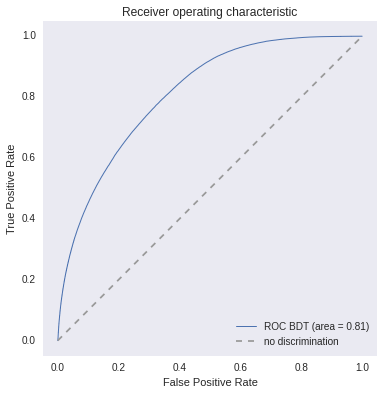

In [10]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Show dependency of BDT quality on the number of trees. 
----------
To obtain this values I use staged_predict_proba

In [ ]:
probas = gb2.staged_predict_proba(new_testX)
tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    tree_scores.append(score)

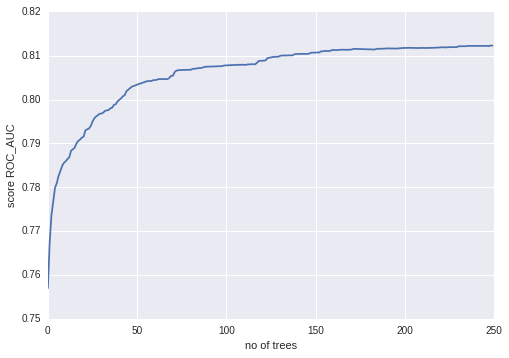

In [31]:
x = numpy.array([x  for x in range(250)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Save model to file 
-------
It is a good idea to save BDT parameters to file for further study.  
I use **sklearn.externals.joblib**. According to the documentation is more effitient than pickle. 

In [54]:
joblib.dump(gb3, 'models/BDT.pkl') 

['models/BDT.pkl',
 'models/BDT.pkl_01.npy',
 'models/BDT.pkl_02.npy',
 'models/BDT.pkl_03.npy']

Extend grid search  range of n_estimators to 600. 
-----------------
This time I want to increase classifier score via extending search space.  
I use data without linear feature transformations. 

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(299,601) if x % 50 == 0],
                   "learning_rate": [0.03,0.1,0.3,1]}
print(gb_grid_params)

gb_gs = GradientBoostingClassifier()

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);

In [7]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 400, 'learning_rate': 0.3}
Grid scores on development set:
0.778 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.03}
0.779 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.03}
0.779 (+/-0.005) for {'n_estimators': 400, 'learning_rate': 0.03}
0.780 (+/-0.005) for {'n_estimators': 450, 'learning_rate': 0.03}
0.780 (+/-0.005) for {'n_estimators': 500, 'learning_rate': 0.03}
0.781 (+/-0.005) for {'n_estimators': 550, 'learning_rate': 0.03}
0.781 (+/-0.005) for {'n_estimators': 600, 'learning_rate': 0.03}
0.784 (+/-0.006) for {'n_estimators': 300, 'learning_rate': 0.1}
0.786 (+/-0.006) for {'n_estimators': 350, 'learning_rate': 0.1}
0.787 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.1}
0.787 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.1}
0.789 (+/-0.006) for {'n_estimators': 500, 'learning_rate': 0.1}
0.789 (+/-0.006) for {'n_estimators': 550, 'learning_rate': 0.1}
0.791 (+/-0.007) for {'n_e

Tune learning rate hyperparameter.
-----------
As I saw before it has large impact on classifier performance.  
To do it I use build-in function **validation_curve**.  
Similarly to  the previous study I use only 10% of data. 

In [ ]:
from sklearn.learning_curve import validation_curve
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )

learning_rates= numpy.arange(0.2,0.8,0.1)
gb_val = GradientBoostingClassifier( n_estimators=400, max_depth=6, max_features=8, verbose=3)


train_scores, test_scores = validation_curve(
    gb_val, train_gs_X, train_gs_Y, 
    param_name="learning_rate", param_range=learning_rates,
    cv=3, scoring="roc_auc", n_jobs=8)


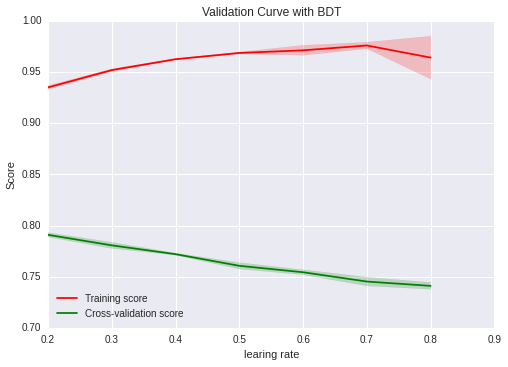

In [11]:

train_scores_mean = numpy.mean(train_scores, axis=1)
train_scores_std = numpy.std(train_scores, axis=1)
test_scores_mean = numpy.mean(test_scores, axis=1)
test_scores_std = numpy.std(test_scores, axis=1) 


plt.title("Validation Curve with BDT ")
plt.xlabel("learing rate")
plt.ylabel("Score")
plt.ylim(0.7, 1)
plt.plot(learning_rates, train_scores_mean, label="Training score", color="r")
plt.fill_between(learning_rates, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(learning_rates, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(learning_rates, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show() 

Train the new model
----------
* n_estimators 400
* learning rate 0.2

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )

gb3 = GradientBoostingClassifier( n_estimators=400, learning_rate=0.2, max_depth=6, max_features=8, verbose=3)
gb3.fit(train_X, train_Y)
joblib.dump(gb3, 'models/gb3.pkl') 

In [7]:
gb3 = joblib.load('models/gb3.pkl')
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

In [8]:
print "ROC AUC score"
roc_auc_score(test_Y, gb3.predict_proba(test_X)[:, 1])

ROC AUC score


0.81319066214145952

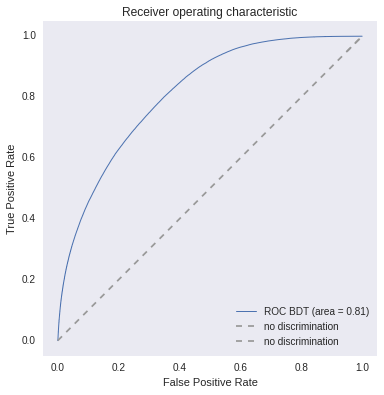

In [11]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [11]:
probas = gb3.staged_predict_proba(test_X)
linear_tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    linear_tree_scores.append(score)

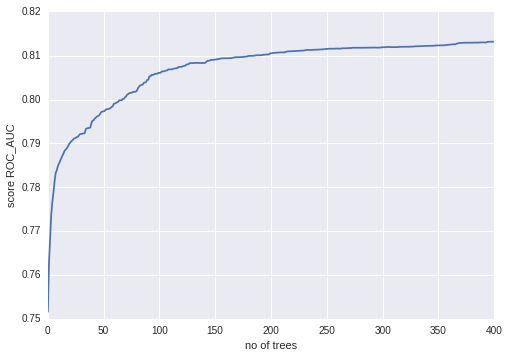

In [14]:
x = numpy.array([x  for x in range(400)])
plt.figure()
plt.plot(x,linear_tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Conclusions
--------
I try to add more features I will use as a number of trees = 150 for further study.  
To get the best, final  result I need to use about 400 trees. 

Add linear combination and ratios of the features
-----------

As a very first step I add such features as 
* number of cluster minus number of layers
* divide -||- 
* pseudo rapidity, momentum and transverse momentum divided by chi2 
* number of hit in OT

And then I will try to find importance of it. 

In [36]:
def add_more_transformations(data):
    out = data
    out["seed_lhcbId-layers"] = data.seed_nLHCbIDs - data.seed_nLayers
    out["seed_ot"] = data.seed_nLHCbIDs - data.seed_nbIT
    out["seed_pr/chi2"] = data.pseudo_rapidity / data.seed_chi2PerDoF
    out["seed_p/chi2"] = data.seed_p/ data.seed_chi2PerDoF
    out["seed_tr"]= numpy.sqrt(numpy.square(data.seed_tx) +numpy.square(data.seed_ty))    
    return out

In [40]:
linear_data = add_more_transformations(new_data)
linear_features = linear_data.drop("is_true_seed", axis=1).astype(numpy.float64)
linear_data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,...,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity,seed_lhcbId-layers,seed_pr/chi2,seed_p/chi2,seed_pt/chi2,seed_ot,seed_tr
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,...,0.524220,0.061572,1364.959300,0.505958,13,0.416870,2095.620933,978.215388,25,0.527823
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,...,0.480288,0.009081,1268.420312,0.463589,13,0.344391,2066.311262,894.722891,25,0.480374
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,...,0.382802,0.025975,1533.677219,0.374842,13,0.230299,2930.298550,1049.691701,25,0.383682
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,...,0.369674,0.058753,1636.317578,0.366082,13,0.204603,2907.907705,1019.396800,25,0.374314
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,...,0.646627,0.054980,1692.412576,0.610352,12,0.480881,1812.867601,986.879812,24,0.648960


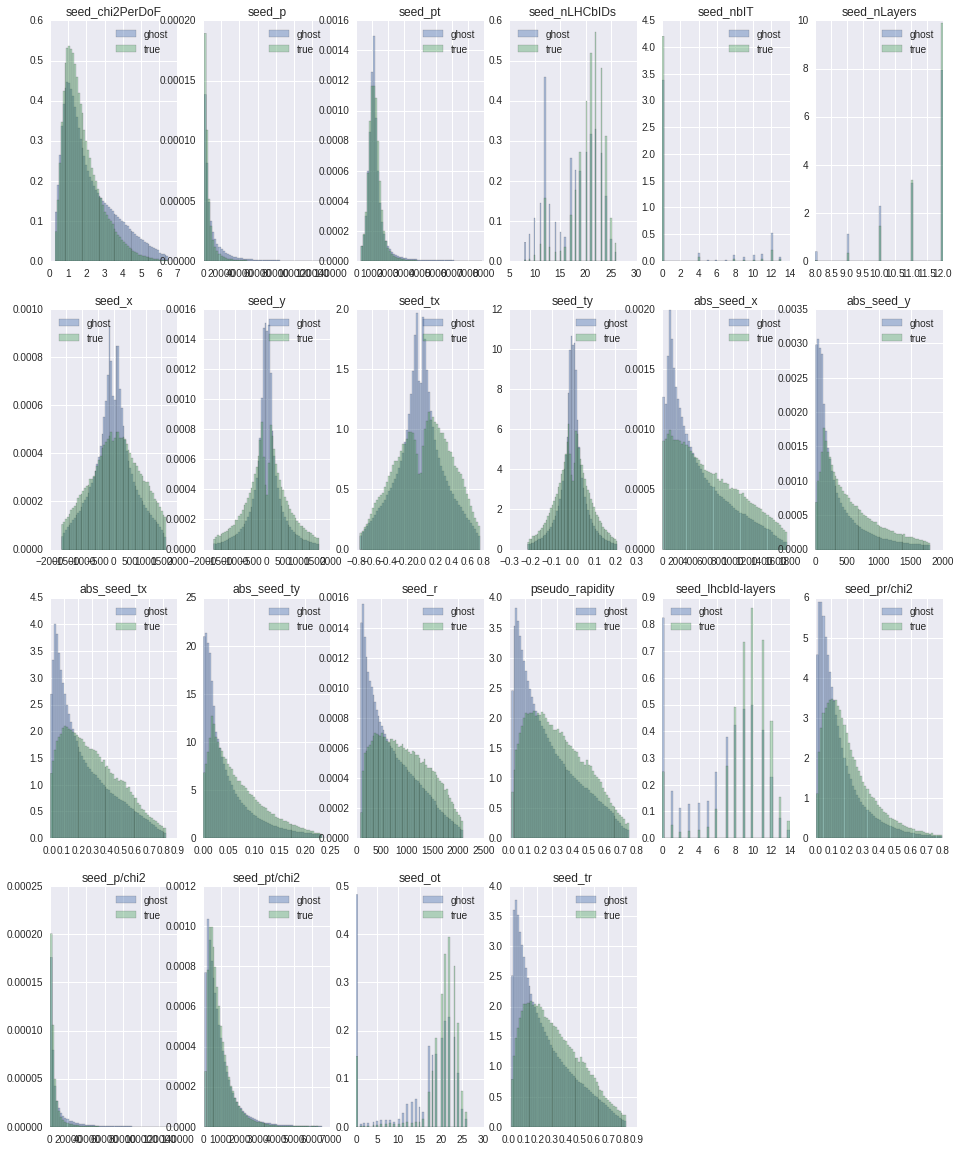

In [41]:
print_features_histograms(linear_features, target)

In [ ]:
linear_trainX, linear_testX, linear_trainY, linear_testY = train_test_split(linear_features, target, random_state=42,train_size=0.5 )
gb_linear= GradientBoostingClassifier(learning_rate=0.2, n_estimators=150, max_depth=6, max_features=8, verbose = 3)
gb_linear.fit(linear_trainX,linear_trainY)
joblib.dump(gb_linear, 'models/BDT_linear.pkl') 

In [25]:
print "ROC AUC score"
roc_auc_score(linear_testY, gb_linear.predict_proba(linear_testX)[:, 1])

ROC AUC score


0.8066236977092156

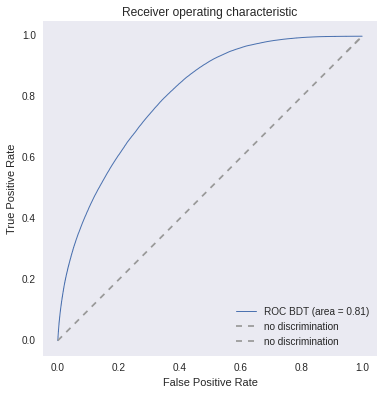

In [26]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(linear_testY, gb_linear.predict_proba(linear_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [29]:
probas = gb_linear.staged_predict_proba(linear_testX)
linear_tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(linear_testY, predicted)
    linear_tree_scores.append(score)

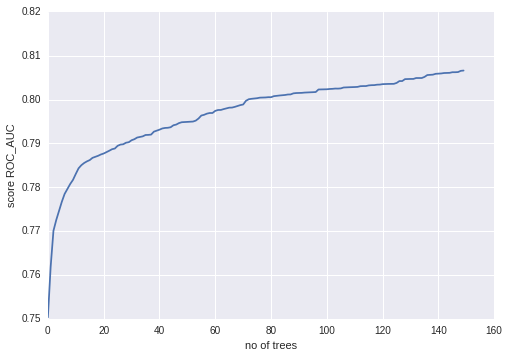

In [31]:
x = numpy.array([x  for x in range(150)])
plt.figure()
plt.plot(x,linear_tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Conclusions 
----------------
1. The linear transformations has no influence on performance of the classifier. 
   I am not going to try another types of such transformation.

Now you can go to the next model - BDT base on [XGBoost]( [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/BDT-XGBoost.ipynb) or [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/LogisticRegression.ipynb)    
=========